In [1]:
import sys
sys.path.append('/n/home12/binxuwang/Github/DiffusionReasoning')
sys.path.append("/n/home12/binxuwang/Github/DiT")
from diffusion import create_diffusion
from models import DiT
from stats_plot_utils import saveallforms, add_rectangles 
from repr_probe_lib import extract_features_DiT, train_pca_sgd_classifiers 
from circuit_toolkit.layer_hook_utils import print_specific_layer, get_module_name_shapes, featureFetcher_module

In [2]:
import os
from os.path import join
import torch 
import torch as th 
import torch.nn as nn
import pickle as pkl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import einops
from torch.utils.data import Dataset, DataLoader, TensorDataset

In [3]:
train_attrs = np.load("/n/home12/binxuwang/Github/DiffusionReasoning/attr_all.npy")
train_attrs = th.from_numpy(train_attrs).to(int)
train_row_img = einops.rearrange(train_attrs, 'c s pnl (H W) att -> c s att H (pnl W)', H=3, W=3, att=3, pnl=3)
train_sample_img = einops.rearrange(train_row_img, 'c (S R) att H W -> c S att (R H) W', R=3,att=3, H=3, W=9)
labels_tsr = torch.arange(len(train_sample_img)).to(int).view(-1,1).repeat(1, train_sample_img.shape[1])

X_train = train_sample_img[:, :3000]
y_train = labels_tsr[:, :3000]
X_test = train_sample_img[:, 3000:]
y_test = labels_tsr[:, 3000:]
X_train = X_train.reshape(-1, 3, 9, 9)
y_train = y_train.reshape(-1)
X_test = X_test.reshape(-1, 3, 9, 9)
y_test = y_test.reshape(-1)
print(X_train.shape, y_train.shape)
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

torch.Size([120000, 3, 9, 9]) torch.Size([120000])


In [4]:
device = "cuda"

In [5]:
# abstract RAVEN dataset
dataset_Xmean = th.tensor([1.5, 2.5, 2.5]).view(1, 3, 1, 1).to(device)
dataset_Xstd = th.tensor([2.5, 3.5, 3.5]).view(1, 3, 1, 1).to(device)

In [8]:
DiT_configs = {
    "DiT_XL_1": {"depth": 28, "hidden_size": 1152, "patch_size": 1, "num_heads": 16},
    "DiT_XL_3": {"depth": 28, "hidden_size": 1152, "patch_size": 3, "num_heads": 16},
    "DiT_L_1": {"depth": 24, "hidden_size": 1024, "patch_size": 1, "num_heads": 16},
    "DiT_L_3": {"depth": 24, "hidden_size": 1024, "patch_size": 3, "num_heads": 16},
    "DiT_B_1": {"depth": 12, "hidden_size": 768, "patch_size": 1, "num_heads": 12},
    "DiT_B_3": {"depth": 12, "hidden_size": 768, "patch_size": 3, "num_heads": 12},
    "DiT_S_1": {"depth": 12, "hidden_size": 384, "patch_size": 1, "num_heads": 6},
    "DiT_S_3": {"depth": 12, "hidden_size": 384, "patch_size": 3, "num_heads": 6},
}
class_dropout_prob = 1.0
num_classes = 0
model_cfg = DiT_configs["DiT_S_1"]
model_DiT = DiT(input_size=9,
            in_channels=3, **model_cfg,
            mlp_ratio=4.0,
            class_dropout_prob=class_dropout_prob,
            num_classes=num_classes,
            learn_sigma=True,)

In [9]:
exproot = r"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiT/results"
expname = r"090-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout0_20240711-0204"
expdir = join(exproot, expname)
ckptdir = join(expdir, "checkpoints")
ckpt_path = join(ckptdir, "1000000.pt")
state_dict = th.load(ckpt_path, )
model_DiT.load_state_dict(state_dict["ema"])
model_DiT.to(device).eval();

In [26]:
figroot = r"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Figures/DiffusionReasoning/representation_geom_few_shot"
figexpdir = join(figroot, expname)
os.makedirs(figexpdir, exist_ok=True)

In [10]:
t_scalar = 25
fetcher = featureFetcher_module()
for i in (5, 8, 11):#range(len(model.blocks)):
    fetcher.record_module(model_DiT.blocks[i], target_name=f"blocks{i}")
train_loader = DataLoader(train_dataset, batch_size=2048, shuffle=False, drop_last=False)
test_loader = DataLoader(test_dataset, batch_size=2048, shuffle=False)
feature_col = extract_features_DiT(model_DiT, fetcher, train_loader, dataset_Xmean, dataset_Xstd, t_scalar)
feature_col_test = extract_features_DiT(model_DiT, fetcher, test_loader, dataset_Xmean, dataset_Xstd, t_scalar)

  0%|          | 0/59 [00:00<?, ?it/s]

blocks5: torch.Size([120000, 81, 384])
blocks8: torch.Size([120000, 81, 384])
blocks11: torch.Size([120000, 81, 384])


  0%|          | 0/20 [00:00<?, ?it/s]

blocks5: torch.Size([40000, 81, 384])
blocks8: torch.Size([40000, 81, 384])
blocks11: torch.Size([40000, 81, 384])


In [11]:
feature_avg_col = {k: v.mean(dim=1) for k, v in feature_col.items()}
feature_avg_col_test = {k: v.mean(dim=1) for k, v in feature_col_test.items()}
feature_last_col = {k: v[:, -1] for k, v in feature_col.items()}
feature_last_col_test = {k: v[:, -1] for k, v in feature_col_test.items()}

### Few shot learing

In [36]:
t_str = 25
ckpt_str = "ckpt1000000EMA"
dimred_str = "avgtoken"
few_samp_num = 75
syn_df_col = []
for few_samp_num in (1, 2, 5, 10, 20, 30, 40, 50, 60, 70, 80, 100, 200):
    print(f"Few shot sample number: {few_samp_num}")
    for rep in range(5):
        subsp_mask = th.zeros(40, 3000, dtype=bool)
        # random index of few samples
        idxs = th.randperm(3000, generator=th.Generator().manual_seed(rep))[:few_samp_num]
        subsp_mask[:, idxs] = True # could randomize this and estimate variance 
        subsp_mask = subsp_mask.flatten()
        feature_avg_col_few = {k: v.mean(dim=1)[subsp_mask,:] for k, v in feature_col.items()}
        y_train_few = y_train[subsp_mask]
        model_PCA_col, PC_proj_col, results_col = train_pca_sgd_classifiers(
            feature_avg_col_few, feature_avg_col_test, y_train_few, y_test,
            PC_dim=None, noPCA=True, num_classes=40, batch_size=None,
            num_epochs=5000, print_every=1000, eval_every=1000, learning_rate=0.005,
            device='cuda'
        )
        pkl.dump(results_col, open(join(figexpdir, f"results_col_t{t_str}_{dimred_str}_{ckpt_str}_fewshot{few_samp_num}_rep{rep}.pkl"), "wb"))
        # pkl.dump(PC_proj_col, open(join(repr_expdir, f"PC_proj_col_t{t_str}_{dimred_str}_{ckpt_str}.pkl"), "wb"))
        # pkl.dump(model_PCA_col, open(join(repr_expdir, f"model_PCA_col_t{t_str}_{dimred_str}_{ckpt_str}.pkl"), "wb"))
        test_acc_synopsis = {key: results_col[key].test_record.accuracy.max() for key in results_col.keys()}
        train_acc_synopsis = {key: results_col[key].train_record.accuracy.max() for key in results_col.keys()}
        syn_df = pd.DataFrame([test_acc_synopsis, train_acc_synopsis]).T
        syn_df.columns = ["Test Accuracy", "Train Accuracy"]
        syn_df["fewshot"] = few_samp_num
        syn_df["dim red"] = dimred_str
        syn_df["ckpt"] = ckpt_str
        syn_df["t"] = t_str
        syn_df["rep"] = rep
        syn_df_col.append(syn_df)    
syn_df_all = pd.concat(syn_df_col)

Few shot sample number: 1
Processing layer: blocks5
Epoch [1/5000], Loss: 3.9287, Accuracy: 0.0250
Epoch [1000/5000], Loss: 0.0000, Accuracy: 1.0000
Test Accuracy: 0.1478
Epoch [2000/5000], Loss: 0.0000, Accuracy: 1.0000
Test Accuracy: 0.1482
Epoch [3000/5000], Loss: 0.0000, Accuracy: 1.0000
Test Accuracy: 0.1487
Epoch [4000/5000], Loss: 0.0000, Accuracy: 1.0000
Test Accuracy: 0.1491
Epoch [5000/5000], Loss: 0.0000, Accuracy: 1.0000
Test Accuracy: 0.1495
Test Accuracy: 0.1495
Layer blocks5 - PCA time: 0.00s, PCA transform time: 0.02s, Training time: 2.88s
Processing layer: blocks8
Epoch [1/5000], Loss: 3.9441, Accuracy: 0.0250
Epoch [1000/5000], Loss: 0.0000, Accuracy: 1.0000
Test Accuracy: 0.3115
Epoch [2000/5000], Loss: 0.0000, Accuracy: 1.0000
Test Accuracy: 0.3126
Epoch [3000/5000], Loss: 0.0000, Accuracy: 1.0000
Test Accuracy: 0.3139
Epoch [4000/5000], Loss: 0.0000, Accuracy: 1.0000
Test Accuracy: 0.3141
Epoch [5000/5000], Loss: 0.0000, Accuracy: 1.0000
Test Accuracy: 0.3153
Test 

In [38]:
# drop index as column Layer
if not "Layer" in syn_df_all.columns:
    syn_df_all.reset_index(inplace=True)
    syn_df_all.rename(columns={"index": "Layer"}, inplace=True)
syn_df_all.to_csv(join(figexpdir, f"few_shot_classify_synopsis_t{t_str}_{dimred_str}_{ckpt_str}.csv"), index=False)

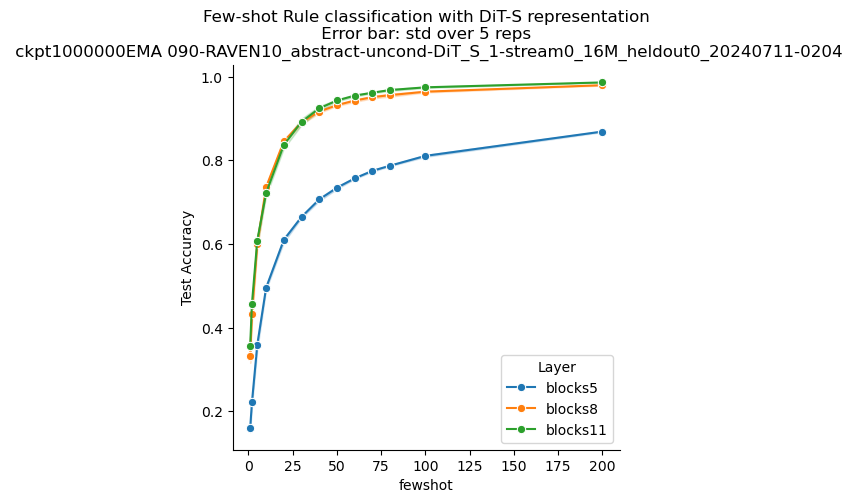

In [51]:
plt.figure(figsize=(5,5))
sns.lineplot(data=syn_df_all, x="fewshot", y="Test Accuracy", hue="Layer", marker="o", errorbar="sd")
plt.title(f"Few-shot Rule classification with DiT-S representation\n Error bar: std over 5 reps \n {ckpt_str} {expname}")
saveallforms(figexpdir, "fewshot_rule_classification_curve_std")

In [55]:
syn_df_all.query("Layer=='blocks11'").groupby("fewshot")["Test Accuracy"].agg(["mean", "std"])

,mean,std
fewshot,,
1,0.356610,0.013373
2,0.457415,0.004626
5,0.608425,0.011631
10,0.722115,0.006822
20,0.836935,0.008270
30,0.892375,0.007665
40,0.924465,0.005671
50,0.943335,0.002550
60,0.954925,0.002456


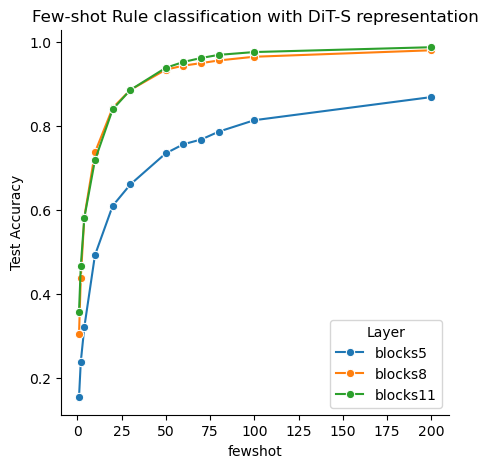

In [33]:
plt.figure(figsize=(5,5))
sns.lineplot(data=syn_df_all, x="fewshot", y="Test Accuracy", hue="Layer", marker="o")
plt.title(f"Few-shot Rule classification with DiT-S representation")
saveallforms(figexpdir, "fewshot_rule_classification_curve")

In [35]:
syn_df_all.query("Layer=='blocks11'")

,Layer,Test Accuracy,Train Accuracy,fewshot,dim red,ckpt,t
2,blocks11,0.358350,1.0,1,avgtoken,ckpt1000000EMA,25
5,blocks11,0.466825,1.0,2,avgtoken,ckpt1000000EMA,25
8,blocks11,0.581975,1.0,4,avgtoken,ckpt1000000EMA,25
11,blocks11,0.718800,1.0,10,avgtoken,ckpt1000000EMA,25
14,blocks11,0.839350,1.0,20,avgtoken,ckpt1000000EMA,25
17,blocks11,0.885725,1.0,30,avgtoken,ckpt1000000EMA,25
20,blocks11,0.938275,1.0,50,avgtoken,ckpt1000000EMA,25
23,blocks11,0.952250,1.0,60,avgtoken,ckpt1000000EMA,25
26,blocks11,0.961675,1.0,70,avgtoken,ckpt1000000EMA,25
29,blocks11,0.969125,1.0,80,avgtoken,ckpt1000000EMA,25


In [22]:
few_samp_num = 5
subsp_mask = th.zeros(40, 3000, dtype=bool)
subsp_mask[:, :few_samp_num] = True
subsp_mask = subsp_mask.flatten()
feature_avg_col_few = {k: v.mean(dim=1)[subsp_mask,:] for k, v in feature_col.items()}
y_train_few = y_train[subsp_mask]

In [23]:
model_PCA_col, PC_proj_col, results_col = train_pca_sgd_classifiers(
    feature_avg_col_few, feature_avg_col_test, y_train_few, y_test,
    PC_dim=512, noPCA=True, num_classes=40, batch_size=None,
    num_epochs=5000, print_every=1000, eval_every=1000, learning_rate=0.005,
    device='cuda'
)

Processing layer: blocks5
Epoch [1/5000], Loss: 3.8366, Accuracy: 0.0350
Epoch [1000/5000], Loss: 0.0004, Accuracy: 1.0000
Test Accuracy: 0.3518
Epoch [2000/5000], Loss: 0.0001, Accuracy: 1.0000
Test Accuracy: 0.3547
Epoch [3000/5000], Loss: 0.0001, Accuracy: 1.0000
Test Accuracy: 0.3564
Epoch [4000/5000], Loss: 0.0000, Accuracy: 1.0000
Test Accuracy: 0.3572
Epoch [5000/5000], Loss: 0.0000, Accuracy: 1.0000
Test Accuracy: 0.3584
Test Accuracy: 0.3584
Layer blocks5 - PCA time: 0.00s, PCA transform time: 0.02s, Training time: 2.89s
Processing layer: blocks8
Epoch [1/5000], Loss: 3.8938, Accuracy: 0.0200
Epoch [1000/5000], Loss: 0.0002, Accuracy: 1.0000
Test Accuracy: 0.6013
Epoch [2000/5000], Loss: 0.0001, Accuracy: 1.0000
Test Accuracy: 0.6074
Epoch [3000/5000], Loss: 0.0000, Accuracy: 1.0000
Test Accuracy: 0.6115
Epoch [4000/5000], Loss: 0.0000, Accuracy: 1.0000
Test Accuracy: 0.6140
Epoch [5000/5000], Loss: 0.0000, Accuracy: 1.0000
Test Accuracy: 0.6159
Test Accuracy: 0.6159
Layer blo

### Export for Shane

In [10]:
!ls $STORE_DIR/DL_Projects

alexnet_rearing        GPT2_raven	     mini_edm
convrnn_Evol	       GPT-XL_grad_trace     resnet-sparsemax-model
CorNet-recurrent-evol  HaimDiffusionRNNProj  SiT
DiT		       insilico_exps	     VAR
edm_analy_traj_cmp     LLM_ft
edm_score_validation   Mamba_raven


In [11]:
!ls /n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Datasets/RPM_dataset/RPM1000k

aR  attr_all_1000k.npy	attr_all_1000k.pt  attr_seq_tsr_all_1000k.pt


In [12]:
X_test.shape

torch.Size([40000, 3, 9, 9])

In [13]:
list(feature_avg_col)

['blocks5', 'blocks8', 'blocks11']

In [14]:
# ['blocks0', 'blocks2', 'blocks5', 'blocks8', 'blocks11']
feature_last_col_test['blocks11'].shape

torch.Size([40000, 384])

In [16]:
savedir = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Datasets/RPM_dataset/DiT_repr_data"
# feature_last_col_test
pkl.dump(feature_col_test, open(join(savedir, "feature_all_token_test.pkl"), "wb"))
pkl.dump(feature_avg_col_test, open(join(savedir, "feature_avg_token_test.pkl"), "wb"))
pkl.dump({"X": X_test, "y": y_test}, open(join(savedir, "X_y_test.pkl"), "wb"))

In [20]:
!du -Sh {savedir}/*

14G	/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Datasets/RPM_dataset/DiT_repr_data/feature_all_token_test.pkl
172M	/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Datasets/RPM_dataset/DiT_repr_data/feature_avg_token_test.pkl
72M	/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Datasets/RPM_dataset/DiT_repr_data/X_y_test.pkl


### Label shuffling classifier test

In [22]:
# shuffle y_train and y_test which are torch tensors
y_train_shuffled = y_train.clone()
y_test_shuffled = y_test.clone()
th.manual_seed(0)
y_train_shuffled = y_train[th.randperm(len(y_train))]
y_test_shuffled = y_test[th.randperm(len(y_test))]

In [23]:
model_PCA_col, PC_proj_col, results_col = train_pca_sgd_classifiers(
    feature_avg_col, feature_avg_col_test, y_train_shuffled, y_test_shuffled,
    PC_dim=1024, noPCA=True, num_classes=40, batch_size=None,
    num_epochs=5000, print_every=250, eval_every=1000, learning_rate=0.005,
    device='cuda'
)

Processing layer: blocks5
Epoch [1/5000], Loss: 3.8623, Accuracy: 0.0251
Epoch [250/5000], Loss: 3.6432, Accuracy: 0.0475
Epoch [500/5000], Loss: 3.6381, Accuracy: 0.0485
Epoch [750/5000], Loss: 3.6362, Accuracy: 0.0484
Epoch [1000/5000], Loss: 3.6351, Accuracy: 0.0493
Test Accuracy: 0.0241
Epoch [1250/5000], Loss: 3.6345, Accuracy: 0.0497
Epoch [1500/5000], Loss: 3.6339, Accuracy: 0.0501
Epoch [1750/5000], Loss: 3.6334, Accuracy: 0.0502
Epoch [2000/5000], Loss: 3.6332, Accuracy: 0.0500
Test Accuracy: 0.0241
Epoch [2250/5000], Loss: 3.6328, Accuracy: 0.0500
Epoch [2500/5000], Loss: 3.6325, Accuracy: 0.0499
Epoch [2750/5000], Loss: 3.6323, Accuracy: 0.0501
Epoch [3000/5000], Loss: 3.6320, Accuracy: 0.0502
Test Accuracy: 0.0242
Epoch [3250/5000], Loss: 3.6319, Accuracy: 0.0503
Epoch [3500/5000], Loss: 3.6318, Accuracy: 0.0502
Epoch [3750/5000], Loss: 3.6317, Accuracy: 0.0503
Epoch [4000/5000], Loss: 3.6315, Accuracy: 0.0503
Test Accuracy: 0.0243
Epoch [4250/5000], Loss: 3.6314, Accuracy: